# STA 141B Data & Web Technologies for Data Analysis

### Lecture 12, 11/14/23, Natural language processing


### Announcements

 - No lecture on Thursday next week. 

### Last Week's topics
- Natural Language Processing
     - `nltk` package
     - Tokenization
     - Regular Expressions
     - Standardizing Text
     - Standardizing Text
     - Feature extraction
         - Term frequencies
         - One-hot encoding

### Today's topics
- Natural Language Processing
    - Term Frequency-Inverse Document Frequency
    - Similarity measures
    - Bigrams
- Latent Dirichlet Allocation

### Ressources
- [Natural Language Processing with Python][nlpp], chapters 1-3. Beware: the print version is for Python 2.
- [Scikit-Learn Documentation][skl], especially the section about [Text Feature Extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)


[PDSH]: https://jakevdp.github.io/PythonDataScienceHandbook/
[ProGit]: https://git-scm.com/book/
[nlpp]: https://www.nltk.org/book/
[atap]: https://search.library.ucdavis.edu/primo-explore/fulldisplay?docid=01UCD_ALMA51320822340003126&context=L&vid=01UCD_V1&search_scope=everything_scope&tab=default_tab&lang=en_US
[skl]: https://scikit-learn.org/stable/documentation.html


### Feature Engineering for Natural Language Data

Most statistical techniques take numbers as input. You may have already noticed this when working with categorical data. We can't compute the mean, median, standard deviation, or z-score if the observations aren't numbers. While we can fit linear models, it takes extra work because we have to create, or _engineer_, indicator variables.

We face the same problem with natural language data. We need to _quantify_ documents, or turn them into numbers, so that we can use a wider variety of statistical techniques. We can do this by engineering features from our documents.

So: what kinds of features can we create for language data?

In [1]:
import numpy as np
import pandas as pd
import nltk, nltk.corpus

#### Term Frequencies

One solution is to extend the idea of frequency analysis. We used frequency analysis to study individual documents, but what if we compute the word frequencies for every document in our corpus, and use those frequencies as features?

Let's try this for a small corpus:

In [2]:
corpus = ["The cat saw the dog was angry at the other cat.", 
          "The dog saw the cat was angry at the other cat.", 
          "The canary saw the iguana was sad."]

def get_freq_doc(doc):
    words = (w.lower() for w in nltk.word_tokenize(doc))
    words = (w for w in words if w not in ["the", "a", "an", "at", 'other', "."] and w.isalnum())
    return nltk.FreqDist(words)

Notice that when we use term frequencies as features, we lose information about the order of the words in each document.

The first and second document contain the same words, but in different orders. The word frequency features for these two documents are identical.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
vec = CountVectorizer(tokenizer = nltk.word_tokenize)
freq = vec.fit_transform(corpus)

In [5]:
freq

<3x12 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [6]:
# .todense() convert sparse matrix to a dense matrix
# Don't do this for a really large matrix!
freq.todense()

matrix([[1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 3, 1],
        [1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 3, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1]])

Use the `.get_feature_names_out()` method to see which term each column corresponds to:

### One-hot Encoding

We can avoid emphasis on high-frequency words by ignoring frequency altogether. Instead, we can create indicator variables for individual words. The indicator is 1 if the word appears in the document, and 0 otherwise.

In machine learning, an indicator variable is also called a _one-hot encoding_.

The `sklearn.preprocessing` submodule of __scikit-learn__ provides a function for one-hot encoding.

In [9]:
from sklearn.preprocessing import Binarizer

In [10]:
binarizer = Binarizer()
ohot = binarizer.fit_transform(freq)
ohot.todense()

matrix([[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]])

### Term Frequency-Inverse Document Frequency

_Term frequency-inverse document frequency_ (tf-idf) statistics put terms on approximately the same scale while also emphasizing relatively rare terms. There are [several different tf-idf statistics](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

The _smoothed tf-idf_, for a term $t$ and document $d$, is given by:

$$
\operatorname{tf-idf}(t, d) = \operatorname{tf}(t, d) \cdot \log \left( \frac{N}{1 + n_t} \right)
$$

where $N$ is the total number of documents and $n_t$ is the number of documents that contain $t$.

The `sklearn.feature_extraction.text` submodule of __scikit-learn__ provides a function for computing tf-idf [docs](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

In [195]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [202]:
vec = TfidfVectorizer(tokenizer = nltk.word_tokenize) #, norm=None) #, use_idf=False)
tfidf = vec.fit_transform(corpus)

In [203]:
vec.get_feature_names_out()

array(['.', 'angry', 'at', 'canary', 'cat', 'dog', 'iguana', 'other',
       'sad', 'saw', 'the', 'was'], dtype=object)

In [204]:
tfidf.todense()

matrix([[0.19894835, 0.25618222, 0.25618222, 0.        , 0.51236445,
         0.25618222, 0.        , 0.25618222, 0.        , 0.19894835,
         0.59684505, 0.19894835],
        [0.19894835, 0.25618222, 0.25618222, 0.        , 0.51236445,
         0.25618222, 0.        , 0.25618222, 0.        , 0.19894835,
         0.59684505, 0.19894835],
        [0.25318288, 0.        , 0.        , 0.42867587, 0.        ,
         0.        , 0.42867587, 0.        , 0.42867587, 0.25318288,
         0.50636575, 0.25318288]])

Term frequency of `.` and `angry` are the same. 

In [205]:
N = 3 # number of documents
nt = 2 # number of documents in which t appears

idf = np.log((N+1)/ (nt+1)) + 1
tf = 1 # absolute frequency of t
tf * idf

1.2876820724517808

In [206]:
corpus

['The cat saw the dog was angry at the other cat.',
 'The dog saw the cat was angry at the other cat.',
 'The canary saw the iguana was sad.']

In long documents or documents with many high-frequency terms, we can further reduce the emphasis on these terms by taking the logarithm of the term frequency. To do this, set `sublinear_tf = True` in the `TfidfVectorizer()` function.

## The Bag-of-words Model

The one-hot encoding, term frequencies, and TF-IDF scores all ignore word order.

The _bag-of-words model_ assumes that the order of words in a document doesn't matter. Imagine taking the words in each document and dumping them into a bag, where they get all mixed up. Note that in this case "model" means a way of thinking about a problem, not a statistical model.

While the order of words in a document might seem important, the bag-of-words model is surprisingly useful. The bag-of-words model is a good place to start if you want to use statistical methods on language data.

## Measuring Similarity

We can measure the _similarity_ of two documents by computing the distance between their term frequency vectors. There are many different ways we can measure distance and similarity:

* Minkowski distance, a family of distances that includes Euclidean distance ($\ell_2$-norm) and Manhattan distance ($\ell_1$-norm). 
 * $\ell_2$-norm, $\|a - b \|_2 = \sqrt{\sum_{i=1}^n (a_i - b_i)^2}$
 * $\ell_1$-norm, $\|a -b\|_1 = \sum_{i=1}^n |a_i - b_i|$

* $\ell_\infty$-norm, $\|a-b\|_\infty = \max_{1\leq i\leq n} |a_i - b_i|$

    * Relation between those norms: $\|\cdot\|_1$ $\geq$ $\|\cdot\|_2$ $\geq$ $\cdots$ $\geq$ $\|\cdot\|_\infty$

* Mahalanobis distance, the Euclidean distance between z-scores.
* Cosine similarity, the cosine of the angle between two vectors. See [here](https://stats.stackexchange.com/a/235676/29695) for an explanation of how cosine similarity is related to correlation. Note that the range of cosine is $[-1, 1]$ and $\cos(0) = 1$, so vectors that are close together will have a cosine similarity close to 1, not 0.
* And others...

Cosine similarity often works well for language data. The cosine similarity between two vectors $a$ and $b$ is defined as:

$$
\frac{a'b}{\Vert a \Vert_2 \Vert b \Vert_2}.
$$

The `TfidfVectorizer()` function already divides the returned tf-idf vectors by their Euclidean norms, so we can compute cosine similarity as a simple dot product:

In [207]:
pd.DataFrame(tfidf.todense())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.198948,0.256182,0.256182,0.000000,0.512364,0.256182,0.000000,0.256182,0.000000,0.198948,0.596845,0.198948
1,0.198948,0.256182,0.256182,0.000000,0.512364,0.256182,0.000000,0.256182,0.000000,0.198948,0.596845,0.198948
2,0.253183,0.000000,0.000000,0.428676,0.000000,0.000000,0.428676,0.000000,0.428676,0.253183,0.506366,0.253183


In [208]:
(tfidf @ tfidf.T).todense()

matrix([[1.        , 1.        , 0.45333284],
        [1.        , 1.        , 0.45333284],
        [0.45333284, 0.45333284, 1.        ]])

Part of the reason that cosine similarity is a good measure in NLP is that cosine similarity, like correlation, is not affected by the scale of the vector elements. For vectors that contain term frequencies (or functions of term frequencies), this means that the length of the original documents will not affect whether or not they are similar -- only their word content will.

### Bigrams

Bigrams (Tri-, ect.) incorporate word order by tokenizing not single words, but two words together. 

In [232]:
corpus

['The cat saw the dog was angry at the other cat.',
 'The dog saw the cat was angry at the other cat.',
 'The canary saw the iguana was sad.']

In [233]:
vec = TfidfVectorizer(tokenizer = nltk.word_tokenize, ngram_range = (1,2)) #, norm=None) #, use_idf=False)
tfidf2 = vec.fit_transform(corpus)

In [234]:
vec.get_feature_names_out()

array(['.', 'angry', 'angry at', 'at', 'at the', 'canary', 'canary saw',
       'cat', 'cat .', 'cat saw', 'cat was', 'dog', 'dog saw', 'dog was',
       'iguana', 'iguana was', 'other', 'other cat', 'sad', 'sad .',
       'saw', 'saw the', 'the', 'the canary', 'the cat', 'the dog',
       'the iguana', 'the other', 'was', 'was angry', 'was sad'],
      dtype=object)

In [235]:
pd.DataFrame(np.transpose(tfidf2.todense()), index = vec.get_feature_names_out())

,0,1,2
.,0.148637,0.148637,0.172003
angry,0.191397,0.191397,0.000000
angry at,0.191397,0.191397,0.000000
at,0.191397,0.191397,0.000000
at the,0.191397,0.191397,0.000000
canary,0.000000,0.000000,0.291227
canary saw,0.000000,0.000000,0.291227
cat,0.382794,0.382794,0.000000
cat .,0.191397,0.191397,0.000000
cat saw,0.251664,0.000000,0.000000


In [237]:
(tfidf2 @ tfidf2.T).todense()

matrix([[1.        , 0.87333072, 0.25566009],
        [0.87333072, 1.        , 0.25566009],
        [0.25566009, 0.25566009, 1.        ]])

Finally, documents one and two are different; even though they are quite similar. Importantly, both are equally different to document three. 

### Summary 

- Standardize text first
- Engineer features depending on priorities

### Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is a probabilistic model for a collection of discrete data. It is motivated to analyise texts. The discrete data consiststs on *words*, that are contain in *documents*, which in turn are collected in the *corpus*. Each document contains differents *topics*, which we are interested in. The topics are not observable, i.e., latent, and have to be estimated. 

- *word* is the smallest entity (token, term) of the discrete data and an element from the dictionary of $D$ words. The $i$-th word of the dictionary is a vector with zero entries except on position $i$. 
- *documents* are a series of $N$ words, denoted as $W = (w_1, \dots, w_N)$. 
- *corpus* is the collection of $M$ documents, $D=\{W_1, \dots, W_M\}$. 

### References
 - [Latent Dirichlet Analysis](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

A LDA is modelled via a Bayesian hierarchy. Before we state it, we have to restate some distributions. 

##### Multinomial

Let $n,k\in\{0,1,2,...\}$ and $p = (p_1, \dots, p_k)'\in[0,1]^k$ with $\sum_{i=1}^kp_i=1$. $X\sim Mult(n,p)$ if 
$$
P(X_1=x_1, \dots, X_k = x_k) = \begin{cases} 
\frac{n!}{x_1\cdots x_k!}p_1^{x_1}\cdots p_k^{x_k}& \text{if}\sum_{i=1}^kx_i = n,\\
0, &\text{else.}
\end{cases}
$$
The Multinomial distribution is a generalization of the Binomial distribution for the case of more than two results. 

##### Dirichlet 

The Dirichlet distribution is a generalization of the Beta distribution. 
A Dirichlet distribution of order $k\geq2$ and parameters $\alpha_1, \dots, \alpha_k>0$ has the p.d.f. 
$$
f(p_1,\dots, p_k) = \frac{\Gamma(\sum_{i=1}^k\alpha_i)}{\prod_{i=1}^k\Gamma(\alpha_i)}\prod_{i=1}^kp_i^{\alpha_i-1}
$$
for all $p_1, \dots, p_k\geq0$ with $\sum_{i=1}^kp_i=1$. This implies that the $p_i$ lie on a $k-1$-dimensional simplex. For $k=2$, the Dirichlet distribution coincides with the Beta distribution. 

An important propery of the Dirichlet distribution is that its a conjugate prior to the Multiomial distribution. Consider the following hierarchy: 
\begin{align}
X|p&\sim Mult(n,p)\\
p&\sim Dir(\alpha)
\end{align}
The parameter $p$ is not assumed to be fixed (as in an frequentist understanding) but random. Consequently, it cannot be estimated. The Bayesian methodology aims in computing the posterior distribution of $p$, given the observed data $X$:
\begin{align}
P(p|X) = \frac{P(X|p)P(p)}{P(X)}
\end{align}
One can show that the posterior probabiliy is again a Dirichlet distribution!

Back to the data! We assume that every document is a collection of latent topics. Each topic is determined by the distribution of words in the document. For each document, we assume the data generating process: 

- Choose $\theta\sim Dir(\alpha)$, where $\theta, \alpha\in\mathbb{R}^k$. 
- For each word $w_i$ in the document $W$, $i = 1, \dots, N$: 
    - Choose a topic $z_i\sim Mult(1,\theta)$,
    - Choose a word from $P(w_i|z_i,\beta)$. 
        
Here, $P(w_i|z_i,\beta)$ is a multinomial probability with $n=1$, given topic $z_i$. We assume that the number of topics $k$ is known and will not be modelled as random for now. The parameter $\beta\in\mathbb{R}^{k\times D}$, and $\beta_{ij}$ is the probability that word $j$ is chosen for topic $i$.

##### Example

Consider as corpus a magazine about housekeeping. This magazine consists of three articles (documents), and each article consists of the topics `home`, `garden`, `cooking` and the words `pan`, `plot`, `window` and `way`. 

In [247]:
topics = np.array(['home', 'garden', 'cooking'])
dictionary = np.array(['pan', 'tree', 'window',  'way'])

For parameters $\alpha_i$, the parameter $\theta$ determines the probability of topics in each document. 

In [249]:
alpha = [1, 2, 3]
theta = np.random.dirichlet(alpha)
theta 

array([0.02863506, 0.3838642 , 0.58750074])

In [251]:
zi = np.random.multinomial(1, theta) # topic for word 
zi

array([0, 0, 1])

In [257]:
beta = np.array([[0.1, 0.02, 0.88, 0],[0.01, 0.79, 0.1, 0.1],[0.75, 0.15, 0.1, 0]])
beta

array([[0.1 , 0.02, 0.88, 0.  ],
       [0.01, 0.79, 0.1 , 0.1 ],
       [0.75, 0.15, 0.1 , 0.  ]])

In [261]:
beta[zi==1,][0]

array([0.75, 0.15, 0.1 , 0.  ])

In [282]:
np.random.multinomial(1,beta[zi==1,][0]) 

array([0, 0, 1, 0])

In [297]:
zi = np.random.multinomial(1, theta) # topic for word 
wi = np.random.multinomial(1, beta[zi==1,][0]) 

print({'topic': topics[zi==1][0]})
print({'word': dictionary[wi==1][0]})

{'topic': 'garden'}
{'word': 'tree'}


The complete corresponding hierarchy is given as 
\begin{align}
    w_i|z_i,\beta_i&\sim Mult(1,\beta_i)\\
    z_i|\theta &\sim Mult(1,\theta)\\
    \theta&\sim Dir(\alpha)
\end{align}

#### [&#128011;](https://www.gutenberg.org/files/2701/2701-h/2701-h.htm)

In [298]:
import nltk, nltk.corpus, re
nltk.download("gutenberg")
moby = nltk.corpus.gutenberg.raw("melville-moby_dick.txt")
moby[1:2000]

[nltk_data] Downloading package gutenberg to /Users/peter/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


'Moby Dick by Herman Melville 1851]\r\n\r\n\r\nETYMOLOGY.\r\n\r\n(Supplied by a Late Consumptive Usher to a Grammar School)\r\n\r\nThe pale Usher--threadbare in coat, heart, body, and brain; I see him\r\nnow.  He was ever dusting his old lexicons and grammars, with a queer\r\nhandkerchief, mockingly embellished with all the gay flags of all the\r\nknown nations of the world.  He loved to dust his old grammars; it\r\nsomehow mildly reminded him of his mortality.\r\n\r\n"While you take in hand to school others, and to teach them by what\r\nname a whale-fish is to be called in our tongue leaving out, through\r\nignorance, the letter H, which almost alone maketh the signification\r\nof the word, you deliver that which is not true." --HACKLUYT\r\n\r\n"WHALE. ... Sw. and Dan. HVAL.  This animal is named from roundness\r\nor rolling; for in Dan. HVALT is arched or vaulted." --WEBSTER\'S\r\nDICTIONARY\r\n\r\n"WHALE. ... It is more immediately from the Dut. and Ger. WALLEN;\r\nA.S. WALW-IAN, to

In [327]:
import re
pattern = r"(?<!,\s{1})(?:ETYMOLOGY|CHAPTER\s{1}\d+|Epilogue|EXTRACTS(?=\s*\())(?:\.*\s*).+?\s*.*[\.{1}|!{1}|\){1}]"
corpus = re.split(pattern, moby)
corpus = [re.sub(r"\W+", " ", document) for document in corpus] # remove typographic symbols
corpus = [document.lower() for document in corpus] # lowercase

corpus.pop(0)
corpus[0:3]

[' the pale usher threadbare in coat heart body and brain i see him now he was ever dusting his old lexicons and grammars with a queer handkerchief mockingly embellished with all the gay flags of all the known nations of the world he loved to dust his old grammars it somehow mildly reminded him of his mortality while you take in hand to school others and to teach them by what name a whale fish is to be called in our tongue leaving out through ignorance the letter h which almost alone maketh the signification of the word you deliver that which is not true hackluyt whale sw and dan hval this animal is named from roundness or rolling for in dan hvalt is arched or vaulted webster s dictionary whale it is more immediately from the dut and ger wallen a s walw ian to roll to wallow richardson s dictionary ketos greek cetus latin whoel anglo saxon hvalt danish wal dutch hwal swedish whale icelandic whale english baleine french ballena spanish pekee nuee nuee fegee pekee nuee nuee erromangoan '

In [329]:
corpus_tokenized = [nltk.word_tokenize(document) for document in corpus]
stopwords = nltk.corpus.stopwords.words("english")
corpus_tokenized = [[word for word in document if word not in stopwords] for document in corpus_tokenized] # remove stopwords
corpus = [' '.join(document) for document in corpus_tokenized]

In [333]:
corpus

['pale usher threadbare coat heart body brain see ever dusting old lexicons grammars queer handkerchief mockingly embellished gay flags known nations world loved dust old grammars somehow mildly reminded mortality take hand school others teach name whale fish called tongue leaving ignorance letter h almost alone maketh signification word deliver true hackluyt whale sw dan hval animal named roundness rolling dan hvalt arched vaulted webster dictionary whale immediately dut ger wallen walw ian roll wallow richardson dictionary ketos greek cetus latin whoel anglo saxon hvalt danish wal dutch hwal swedish whale icelandic whale english baleine french ballena spanish pekee nuee nuee fegee pekee nuee nuee erromangoan',
 'seen mere painstaking burrower grub worm poor devil sub sub appears gone long vaticans street stalls earth picking whatever random allusions whales could anyways find book whatsoever sacred profane therefore must every case least take higgledy piggledy whale statements howeve

In [334]:
len(corpus)

137

Now, we will use the [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). 

We will have to reshape our corpus into a sparse matrix. Lets use hot one encoding. 

In [335]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer

In [336]:
vec = CountVectorizer(tokenizer = nltk.word_tokenize)
freq = vec.fit_transform(corpus)
ohot = Binarizer().fit_transform(freq)
corpus_binary = ohot.todense()

In [337]:
corpus_binary

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [338]:
corpus_binary = np.asarray(corpus_binary)
corpus_binary 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [341]:
corpus_binary.shape # some words less than when checked last time, due to stopword removal

(137, 16856)

In [342]:
vec.get_feature_names_out()

array(['000', '1', '10', ..., 'zones', 'zoology', 'zoroaster'],
      dtype=object)

In [343]:
from sklearn.decomposition import LatentDirichletAllocation

In [346]:
ntopics = 2
lda = LatentDirichletAllocation(n_components = ntopics, learning_method = 'online')

In [347]:
lda.fit(corpus_binary)

LatentDirichletAllocation(learning_method='online', n_components=2)

Now what? Lets investigate if the topic distribution changes over the chapters. 

In [352]:
posterior = lda.transform(corpus_binary)
posterior 

array([[7.50539531e-01, 2.49460469e-01],
       [6.37807208e-01, 3.62192792e-01],
       [4.69584405e-01, 5.30415595e-01],
       [2.53141479e-02, 9.74685852e-01],
       [4.77145581e-01, 5.22854419e-01],
       [3.03157301e-03, 9.96968427e-01],
       [1.47666001e-01, 8.52333999e-01],
       [5.14188672e-01, 4.85811328e-01],
       [2.07194704e-02, 9.79280530e-01],
       [3.80872296e-03, 9.96191277e-01],
       [3.15960837e-03, 9.96840392e-01],
       [1.16209568e-02, 9.88379043e-01],
       [1.18378155e-01, 8.81621845e-01],
       [3.62646275e-03, 9.96373537e-01],
       [1.62270066e-03, 9.98377299e-01],
       [4.88520893e-01, 5.11479107e-01],
       [3.76005365e-01, 6.23994635e-01],
       [4.56520637e-01, 5.43479363e-01],
       [3.00720637e-01, 6.99279363e-01],
       [2.04477434e-03, 9.97955226e-01],
       [2.20481448e-03, 9.97795186e-01],
       [3.34059593e-03, 9.96659404e-01],
       [1.96113525e-03, 9.98038865e-01],
       [1.40031046e-03, 9.98599690e-01],
       [4.203213

In [353]:
sum(posterior[0])

1.0

In [354]:
import plotnine as p9
import pandas as pd

In [355]:
df = pd.DataFrame(posterior).reset_index()
df.columns = ['chapter'] + ['topic ' + str(i) for i in range(0,ntopics)]
df

,chapter,topic 0,topic 1
0,0,0.750540,0.249460
1,1,0.637807,0.362193
2,2,0.469584,0.530416
3,3,0.025314,0.974686
4,4,0.477146,0.522854
...,...,...,...
132,132,0.000906,0.999094
133,133,0.000466,0.999534
134,134,0.000487,0.999513
135,135,0.000416,0.999584


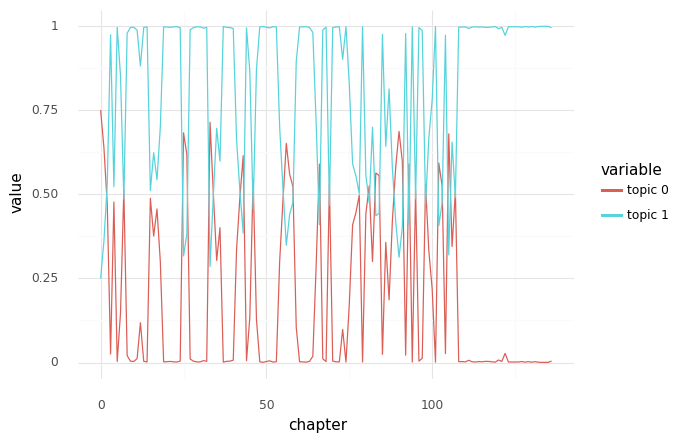

<ggplot: (8775858151376)>

In [356]:
(
p9.ggplot(pd.melt(df, id_vars = 'chapter'),
    p9.aes(x='chapter',y='value',color='variable')) + p9.theme_minimal() + 
    p9.geom_line() 
)

In [359]:
df[(df['topic 1']>0.5).values] # chapters of topic 1

,chapter,topic 0,topic 1
2,2,0.469584,0.530416
3,3,0.025314,0.974686
4,4,0.477146,0.522854
5,5,0.003032,0.996968
6,6,0.147666,0.852334
...,...,...,...
132,132,0.000906,0.999094
133,133,0.000466,0.999534
134,134,0.000487,0.999513
135,135,0.000416,0.999584


In [363]:
df.iloc[50]

chapter    50.000000
topic 0     0.002949
topic 1     0.997051
Name: 50, dtype: float64

In [365]:
df.iloc[55]

chapter    55.000000
topic 0     0.483557
topic 1     0.516443
Name: 55, dtype: float64

In [366]:
lda.components_

array([[2.27196789, 0.97758313, 1.41775649, ..., 0.56217618, 0.99238969,
        0.53732999],
       [0.70972846, 0.5545173 , 0.61515045, ..., 1.93334792, 0.54822368,
        1.01693635]])

In [367]:
len(lda.components_[0])

16856

In [368]:
corpus_binary.shape

(137, 16856)

In [369]:
wordTopics = pd.DataFrame(lda.components_.T, index = vec.get_feature_names_out())
wordTopics

,0,1
000,2.271968,0.709728
1,0.977583,0.554517
10,1.417756,0.615150
105,0.945274,0.591339
13,1.388781,0.629140
...,...,...
zone,0.566660,9.347494
zoned,1.062124,0.971513
zones,0.562176,1.933348
zoology,0.992390,0.548224


In [370]:
wordTopics = wordTopics.apply(lambda x: x / sum(x), 1)
wordTopics = wordTopics.reset_index()
wordTopics.columns = ['word'] + ['topic ' + str(i) for i in range(0,ntopics)]
wordTopics

,word,topic 0,topic 1
0,000,0.761972,0.238028
1,1,0.638067,0.361933
2,10,0.697404,0.302596
3,105,0.615167,0.384833
4,13,0.688224,0.311776
...,...,...,...
16851,zone,0.057157,0.942843
16852,zoned,0.522278,0.477722
16853,zones,0.225274,0.774726
16854,zoology,0.644152,0.355848


In [371]:
wordTopics.sort_values(by = 'topic 1', ascending = False)['word'].iloc[1:10]

9356      missing
374          ahab
13927    starbuck
9388         moby
14062       stood
6592           ha
4491      dropped
5397         fate
3461        cried
Name: word, dtype: object

In [373]:
wordTopics.sort_values(by = 'topic 0', ascending = False)['word'].iloc[1:10]

8535     leviathanic
7119      hospitable
7034         holland
9452       monstrous
7477        inclined
427          alleged
6722       harpooned
2863        commerce
11145            pre
Name: word, dtype: object